In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import re
from sklearn.linear_model import LinearRegression

In [8]:
# config matplotlib
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

In [9]:
# helper function
def remove_unused_labels(data: pd.DataFrame):
    unused_labels = ['學校統計處代碼', '學期', '設立別', '學校類別', '學校統計', '處代碼', '系所代碼', '系所名稱',
                     '學制班別', '性別', '學制班別(日間)', '在學學生數']
    for label in unused_labels:
        if label not in data.columns:
            continue
        data = data.drop(label, axis=1)
    return data

def rename_columns(data: pd.DataFrame):
    columns = list(data.columns)
    for index, column in enumerate(columns):
        columns[index] = re.sub('申請延長修業年限因素之學生人數-', '延修人數-', columns[index])
        columns[index] = re.sub('於學年底處於休學狀態之人數-', '休學人數-', columns[index])
        columns[index] = re.sub('學期間退學人數-', '退學人數-', columns[index])
        columns[index] = re.sub('在學學生數', '在學學生數-', columns[index])
        columns[index] = re.sub('小計', '總計', columns[index])
    data.columns = columns
    return data

def convert_to_average_rank(rank: str):
    rank = rank.replace("-", "–") # there are two types of dashes in the dataset, so we replace it with "–"
    if "–" in rank:  # check if the rank contains "–"
        numbers = map(int, rank.split("–"))  # split the rank into two numbers
        return sum(numbers) / 2  # calculate the average of the two numbers
    else:
        return int(rank)  # return the rank as an integer
        

In [10]:
# 1. 台灣大學學生資料
# create folder if not exist
if not os.path.exists('./data'):
    os.makedirs('./data')

# define categories and urls
categories = ['在學學生數', '延修', '休學', '退學']
urls = [
    "https://udb.moe.edu.tw/download/udata/static_file/%E5%AD%B81-1.%E6%AD%A3%E5%BC%8F%E5%AD%B8%E7%B1%8D%E5%9C%A8%E5%AD%B8%E5%AD%B8%E7%94%9F%E4%BA%BA%E6%95%B8-%E4%BB%A5%E3%80%8C%E7%B3%BB(%E6%89%80)%E3%80%8D%E7%B5%B1%E8%A8%88.csv",
    "https://udb.moe.edu.tw/download/udata/static_file/%E5%AD%B84.%E6%97%A5%E9%96%93%E5%AD%B8%E5%A3%AB%E7%8F%AD%E4%BB%A5%E4%B8%8B%E7%94%B3%E8%AB%8B%E5%BB%B6%E9%95%B7%E4%BF%AE%E6%A5%AD%E5%B9%B4%E9%99%90%E4%B9%8B%E5%BB%B6%E4%BF%AE%E7%94%9F%E6%95%B8-%E4%BB%A5%E3%80%8C%E7%B3%BB(%E6%89%80)%E3%80%8D%E7%B5%B1%E8%A8%88.csv",
    "https://udb.moe.edu.tw/download/udata/static_file/%E5%AD%B813-1.%E6%96%BC%E5%AD%B8%E5%B9%B4%E5%BA%95%E8%99%95%E6%96%BC%E4%BC%91%E5%AD%B8%E7%8B%80%E6%85%8B%E4%B9%8B%E4%BA%BA%E6%95%B8-%E4%BB%A5%E3%80%8C%E7%B3%BB(%E6%89%80)%E3%80%8D%E7%B5%B1%E8%A8%88(110%E5%AD%B8%E5%B9%B4%E5%BA%A6%E4%BB%A5%E5%89%8D).csv",
    "https://udb.moe.edu.tw/download/udata/static_file/%E5%AD%B814-1.%E9%80%80%E5%AD%B8%E4%BA%BA%E6%95%B8-%E4%BB%A5%E3%80%8C%E7%B3%BB(%E6%89%80)%E3%80%8D%E7%B5%B1%E8%A8%88(110%E5%AD%B8%E5%B9%B4%E5%BA%A6%E4%BB%A5%E5%89%8D).csv"
]

# download data
datum = {}
for url, category in zip(urls, categories):
    data = pd.read_csv(url, low_memory=False)
    data = remove_unused_labels(data)
    data = rename_columns(data)
    data.replace('...', 0, inplace=True)
    datum[category] = data

# split data by year
for year in range(106, 111):  # 106 ~ 110
    merged_data = pd.DataFrame()
    for category in categories:
        data = datum[category]
        data = data[data["學年度"] == year]
        data = data.drop(["學年度"], axis=1)
        data = data.astype({col: int for col in data.columns[1:]})  # convert to int, ignore the first column
        data = data.groupby("學校名稱").sum().reset_index()
        merged_data = pd.concat([merged_data, data], ignore_index=True, join="outer")
    merged_data.fillna(0, inplace=True)
    merged_data = merged_data.astype({col: int for col in merged_data.columns[1:]})
    merged_data = merged_data.groupby("學校名稱").sum().reset_index()
    merged_data.to_csv(f'./data/{year}.csv', index=False)

In [11]:
# 2. THE ranking (泰晤士學校排名)
name_converter = {
    "National Taiwan University (NTU)": "國立臺灣大學",
    "National Tsing Hua University": "國立清華大學",
    "National Chiao Tung University": "國立陽明交通大學",
    "National Taiwan University of Science and Technology (Taiwan Tech)": "國立臺灣科技大學",
    "Taipei Medical University": "臺北醫學大學",
    "National Cheng Kung University (NCKU)": "國立成功大學",
    "China Medical University, Taiwan": "中國醫藥大學",
    "National Taiwan Normal University": "國立臺灣師範大學",
    "Chang Gung University": "長庚大學",
    "Kaohsiung Medical University": "高雄醫學大學",
    "National Central University": "國立中央大學",
    "National Chengchi University": "國立政治大學",
    "National Sun Yat-Sen University": "國立中山大學",
    "National Yang-Ming University": "國立陽明大學",
    "Asia University, Taiwan": "亞洲大學",
    "Chung Yuan Christian University": "中原大學",
    "Feng Chia University": "逢甲大學",
    "Fu Jen Catholic University": "輔仁大學",
    "I-Shou University": "義守大學",
    "National Chung Cheng University": "國立中正大學",
    "National Chung Hsing University": "國立中興大學",
    "National Dong Hwa University": "國立東華大學",
    "National Taipei University": "國立臺北大學",
    "National Taipei University of Technology": "國立臺北科技大學",
    "National Taiwan Ocean University": "國立臺灣海洋大學",
    "Yuan Ze University": "元智大學",
    "National University of Tainan": "國立臺南大學",
}

for year in range(106, 111):  # 106 ~ 110
    data = pd.read_csv(f'./data/{year + 1911}_rankings.csv')
    data["rank"] = data["rank"].str.replace(r"=", "")  # remove "=" in renk column
    data = data[~data["rank"].str.contains(r"\+")]  # filter out all "rank" with "+"
    data = data[data["location"] == "Taiwan"]
    data = data[["rank", "name", "scores_overall"]]
    data["name"] = data["name"].map(name_converter)  # convert name to Chinese
    data.columns = ["排名", "學校名稱", "總分"]  # rename columns
    old_data = pd.read_csv(f'./data/{year}.csv') # read old data
    old_data['總分'] = str() # add new column name "總分"
    old_data['排名'] = str() # add new column name "排名"
    for index, row in data.iterrows(): # add data to old_data
        school_name = row["學校名稱"]
        # if school is not in old_data (此行可以解決陽明交通大學合併導致的名稱不一問題)
        if school_name not in old_data['學校名稱']: 
            pass
        old_data.loc[old_data['學校名稱'] == school_name, '總分'] = row.loc["總分"]
        old_data.loc[old_data['學校名稱'] == school_name, '排名'] = row.loc["排名"]
    old_data.to_csv(f'./data/{year}.csv', index=False)
    

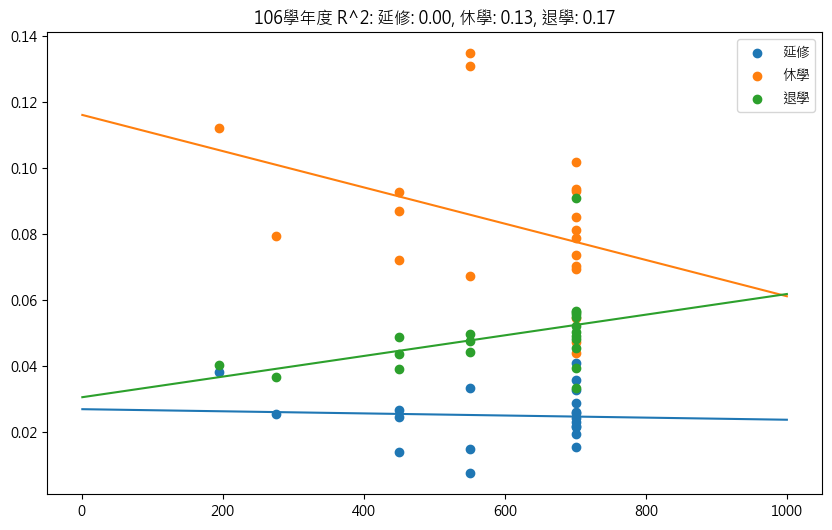

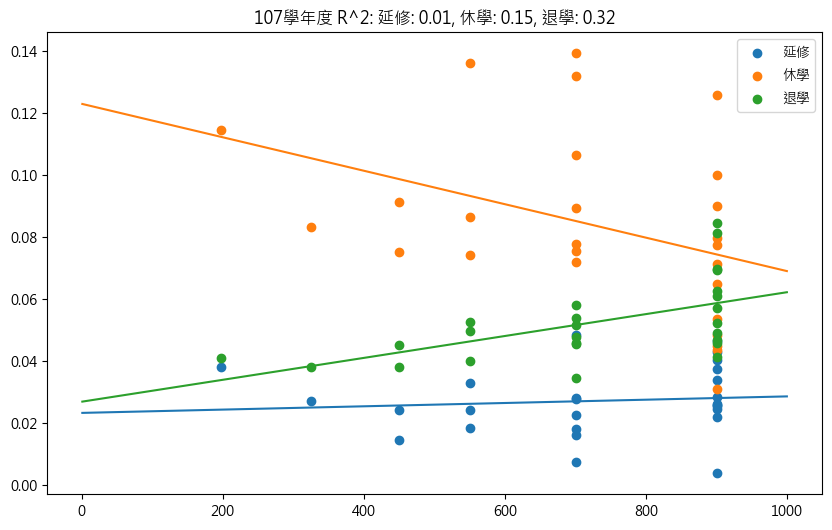

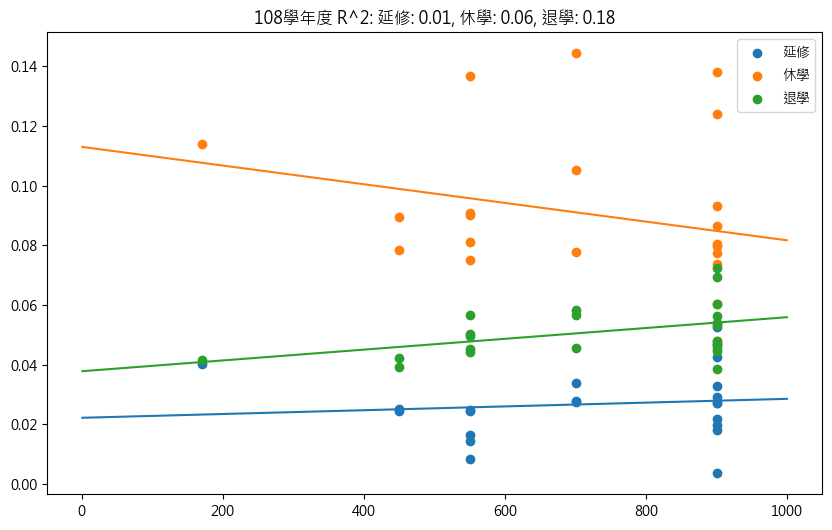

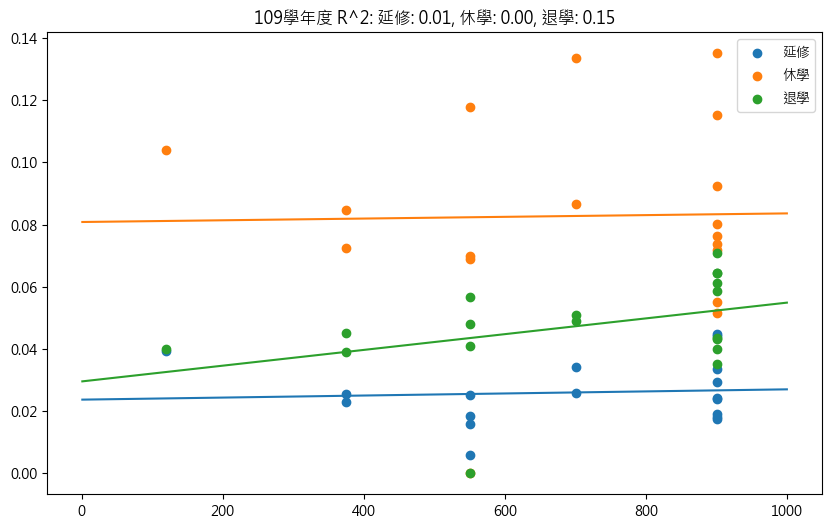

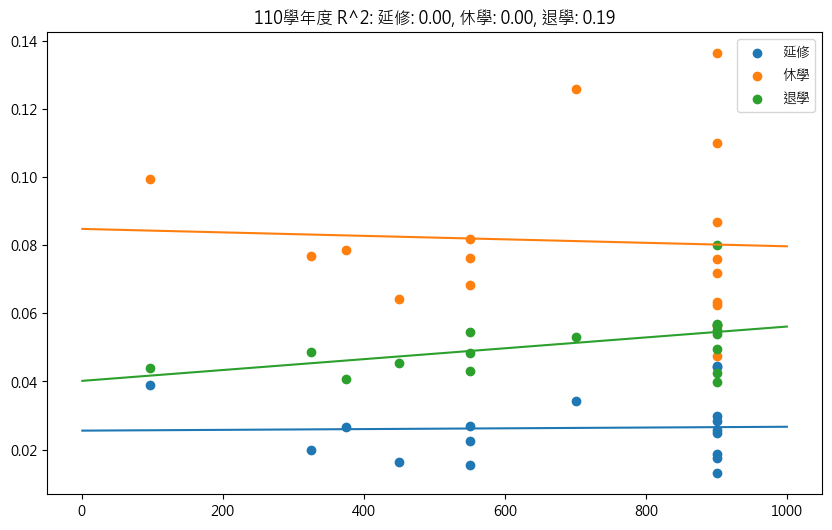

'\nconclusion:\n大學排名 對 退學率 相較 延修率 及 休學率 有較大的影響\n'

In [12]:
# 3. filter data and calculate ratio of '延修', '休學', '退學'
for year in range(106, 111):  # 106 ~ 110
    data = pd.read_csv(f'./data/{year}.csv')
    attributes = ['延修', '休學', '退學']
    for attribute in attributes:
        data[f"{attribute}率"] = data[f'{attribute}人數-總計'] / data['在學學生數-總計']
    data = data[['學校名稱', '排名', '延修率', '休學率', '退學率']]
    plt.figure(figsize=(10, 6))
    data = data.dropna(subset=['排名']) # ignore schools without rank
    data.to_csv(f'./data/{year}_simplified.csv', index=False)
    scores = {} # store regression score
    for attribute in attributes:
        regression = LinearRegression()
        func = np.vectorize(convert_to_average_rank)
        dataset_x = func(data['排名'].values.reshape(-1, 1))
        dataset_y = data[f"{attribute}率"].values.reshape(-1, 1).ravel()
        regression.fit(dataset_x, dataset_y)
        score = regression.score(dataset_x, dataset_y)
        scores[attribute] = score
        all_x = np.arange(1, 1000, 0.1).reshape(-1, 1)
        plt.plot(all_x, regression.predict(all_x))
        plt.scatter(dataset_x, dataset_y, label=attribute)
    plt.legend()
    title = f'{year}學年度 R^2: ' + ', '.join([f'{attribute}: {scores[attribute]:.2f}' for attribute in attributes])
    plt.title(title)
    plt.show()
    
'''
conclusion:
大學排名 對 退學率 相較 延修率 及 休學率 有較大的影響
'''

In [ ]:
'''
# deprecated code
# 4. 退學率中的哪些因素影響排名較大
results = pd.DataFrame(columns=range(106, 111))
for year in range(106, 111):  # 106 ~ 110
    data = pd.read_csv(f'./data/{year}.csv')
    attributes = list(filter(lambda x: "退學" in x, data.columns))
    data = data[attributes + ['學校名稱', '排名', '在學學生數-總計']] # add "在學學生數-總計" to get ratio
    data = data.dropna(subset=['排名']) # ignore schools without rank
    scores = {} # store regression score
    for attribute in attributes:
        regression = LinearRegression()
        func = np.vectorize(convert_to_average_rank)
        dataset_x = func(data['排名'].values.reshape(-1, 1))
        dataset_y = (data[attribute]/data['在學學生數-總計']).values.reshape(-1, 1).ravel() # calculate ratio
        regression.fit(dataset_x, dataset_y)
        score = regression.score(dataset_x, dataset_y)
        scores[attribute] = score
    results[year] = scores
print("\n退學率中的哪些因素影響排名較大\n")
output = results.to_markdown(tablefmt='pipe', colalign=['center'] * len(results.columns))
output = output.split('\n')[:1] + output.split('\n')[2:]
print('\n'.join(output))
'''